# Discrete Quantum Walk on a Circle

This notebook demonstrates the capabilities of the synthesis engine for a walk operator on a circle. The walk operator acts on two quantum variables: a coin qubit and a position quantum number. The core part of the walk operator is the increment quantum function, which is implemented here via a series of multi-controlled X operation.

In [1]:
import time

import numpy as np

from classiq import *

In [2]:
transpilation_options = {"classiq": "custom", "qiskit": 3}
NUM_QUBITS_MIN = 5
NUM_QUBITS_MAX = 12

In [3]:
# define increment circuit as an MCX cascade
@qfunc
def increment(x: QArray):
    repeat(
        x.len - 1, lambda i: control(x[0 : x.len - 1 - i], lambda: X(x[x.len - 1 - i]))
    )
    X(x[0])


@qfunc
def single_step_walk(
    coin: QBit,  # coin
    x: QNum,  # position
):
    H(coin)
    control(coin == 0, lambda: increment(x)),
    control(coin == 1, lambda: invert(lambda: increment(x)))

In [4]:
preferences = Preferences(
    custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    transpilation_option=transpilation_options["classiq"],
)

## Synthesizing with two Different Optimization Scenarios 

In [5]:
classiq_depths_opt_width = []
classiq_cx_counts_opt_width = []
classiq_widths_opt_width = []
classiq_times_opt_width = []

classiq_cx_counts_opt_cx = []
classiq_depths_opt_cx = []
classiq_widths_opt_cx = []
classiq_times_opt_cx = []


qprogs_width = []
qprogs_cx = []

for num_qubits in range(NUM_QUBITS_MIN, NUM_QUBITS_MAX):
    print(num_qubits, "======")

    @qfunc
    def main(x: Output[QNum[num_qubits]], coin: Output[QBit]):
        allocate(x)
        allocate(coin)
        single_step_walk(coin, x)

    # width optimization
    constraints = Constraints(optimization_parameter=OptimizationParameter.WIDTH)
    start_time = time.time()
    qprog = synthesize(main, preferences=preferences, constraints=constraints)
    end_time = time.time() - start_time
    qprogs_width.append(qprog)

    classiq_widths_opt_width.append(qprog.data.width)
    classiq_depths_opt_width.append(qprog.transpiled_circuit.depth)
    classiq_cx_counts_opt_width.append(qprog.transpiled_circuit.count_ops["cx"])
    classiq_times_opt_width.append(end_time)
    print("time (width):", end_time)

    # CX Optimization with a Constrained Width
    constraints = Constraints(
        optimization_parameter="cx",
        max_width=2 * num_qubits,  # setting some bound
    )
    start_time = time.time()
    qprog = synthesize(main, preferences=preferences, constraints=constraints)
    end_time = time.time() - start_time
    qprogs_cx.append(qprog)

    classiq_widths_opt_cx.append(qprog.data.width)
    classiq_depths_opt_cx.append(qprog.transpiled_circuit.depth)
    classiq_cx_counts_opt_cx.append(qprog.transpiled_circuit.count_ops["cx"])
    classiq_times_opt_cx.append(end_time)
    print("time (cx)   :", end_time)

5 ======
time (width): 17.124277114868164
time (cx)   : 11.192315816879272
6 ======
time (width): 21.591820240020752
time (cx)   : 15.177436828613281
7 ======
time (width): 31.07102370262146
time (cx)   : 21.30684185028076
8 ======
time (width): 64.84211993217468
time (cx)   : 30.741410970687866
9 ======
time (width): 65.00351119041443
time (cx)   : 30.816946983337402
10 ======
time (width): 91.25923418998718
time (cx)   : 44.58564019203186
11 ======
time (width): 116.76875686645508
time (cx)   : 44.52197813987732


In [6]:
print("classiq depths:", classiq_depths_opt_width)
print("classiq cx_counts:", classiq_cx_counts_opt_width)
print("classiq widths:", classiq_widths_opt_width)
print(classiq_times_opt_width)

print("classiq depths:", classiq_depths_opt_cx)
print("classiq cx_counts:", classiq_cx_counts_opt_cx)
print("classiq widths:", classiq_widths_opt_cx)
print(classiq_times_opt_cx)

classiq depths: [419, 745, 1187, 1761, 2483, 3369, 4079]
classiq cx_counts: [272, 510, 844, 1290, 1864, 2582, 3182]
classiq widths: [6, 7, 8, 9, 10, 11, 13]
[17.124277114868164, 21.591820240020752, 31.07102370262146, 64.84211993217468, 65.00351119041443, 91.25923418998718, 116.76875686645508]
classiq depths: [191, 243, 331, 413, 501, 593, 693]
classiq cx_counts: [120, 152, 200, 260, 352, 436, 552]
classiq widths: [8, 9, 11, 12, 14, 15, 17]
[11.192315816879272, 15.177436828613281, 21.30684185028076, 30.741410970687866, 30.816946983337402, 44.58564019203186, 44.52197813987732]


## Comparing to Qiskit Implementation

The qiskit data was generated using qiskit version 1.0.0. To run the qiskit code uncomment the commented cells below.

In [7]:
qiskit_cx_counts = [900, 2376, 5388, 11472, 23700, 48216]
qiskit_depths = [1645, 4222, 9485, 20122, 41509, 84398]
qiskit_widths = [6, 7, 8, 9, 10, 11]
qiskit_times = [
    0.43783092498779297,
    3.743027925491333,
    17.858744144439697,
    73.1058611869812,
    293.51222825050354,
    1222.052798986435,
]

In [8]:
# from qiskit import QuantumCircuit, QuantumRegister, transpile

# def get_incerement_circuit(num_qubits):

#     incerement_circuit= QuantumCircuit(num_qubits)
#     for j in range(num_qubits - 1):
#         incerement_circuit.mcx([k for k in range(num_qubits - 1-j)], num_qubits-1-j)
#     incerement_circuit.x(0)

#     return incerement_circuit

# # building the q_walk_step, the first qubit is the coin
# qiskit_cx_counts = []
# qiskit_depths = []
# qiskit_widths = []
# qiskit_times = []


# for num_qubits in range(NUM_QUBITS_MIN,NUM_QUBITS_MAX):

#     start_time = time.time()
#     q_walk_step = QuantumCircuit(num_qubits+1)
#     q_walk_step.h(0)
#     q_walk_step.append(get_incerement_circuit(num_qubits).control(1, ctrl_state=1),
#                              [k for k in range(num_qubits+1)])
#     q_walk_step.append(get_incerement_circuit(num_qubits).inverse().control(1, ctrl_state=0),
#                              [k for k in range(num_qubits+1)])
#     transpiled_cir = transpile(
#             q_walk_step,
#             basis_gates=["u", "cx"],
#             optimization_level=transpilation_options["qiskit"],
#     )
#     print(time.time()-start_time, ",  ",num_qubits)
#     print(transpiled_cir.depth())
#     qiskit_depths.append(transpiled_cir.depth())
#     qiskit_cx_counts.append(transpiled_cir.count_ops()["cx"])
#     qiskit_widths.append(transpiled_cir.width())
#     qiskit_times.append(time.time()-start_time)


# print(qiskit_cx_counts)
# print(qiskit_depths)
# print(qiskit_widths)
# print(qiskit_times)

In [9]:
num_qubits_classiq = range(NUM_QUBITS_MIN, NUM_QUBITS_MAX)
num_qubits_qiskit = num_qubits_classiq[0 : len(qiskit_cx_counts)]

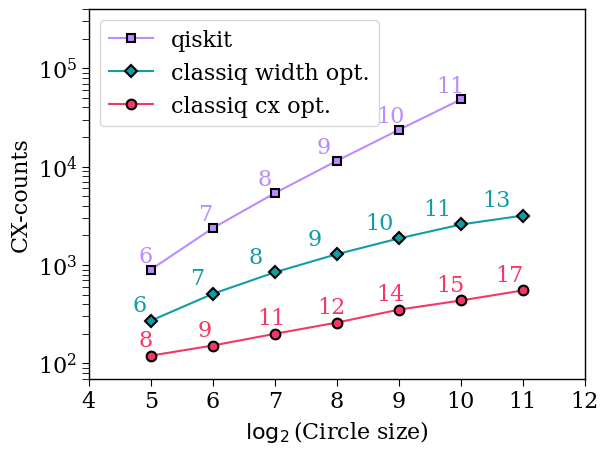

In [10]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
classiq_color_1 = "#F43764"
qiskit_color = "#bb8bff"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

(qiskit1,) = plt.semilogy(
    num_qubits_qiskit,
    qiskit_cx_counts,
    "-s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=6,
    markeredgewidth=1.5,
    color=qiskit_color,
)

(classiq1,) = plt.semilogy(
    num_qubits_classiq,
    classiq_cx_counts_opt_width,
    "-D",
    label="classiq width opt.",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=6.5,
    markeredgewidth=1.5,
    color=classiq_color,
)

(classiq2,) = plt.semilogy(
    num_qubits_classiq,
    classiq_cx_counts_opt_cx,
    "-o",
    label="classiq cx opt.",
    markerfacecolor=classiq_color_1,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color_1,
)


first_legend = plt.legend(
    handles=[qiskit1, classiq1, classiq2], fontsize=16, loc="upper left"
)


plt.ylabel("CX-counts", fontsize=16)
plt.xlabel(r"$\log_2$(Circle size)", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axis(ymin=0.7e2, ymax=4e5, xmin=4, xmax=12)


for x, y, num_qubits in zip(
    num_qubits_classiq, classiq_cx_counts_opt_width, classiq_widths_opt_width
):
    plt.text(x * 0.94, y * 1.25, str(num_qubits), fontsize=16, color=classiq_color)

for x, y, num_qubits in zip(
    num_qubits_classiq,
    classiq_cx_counts_opt_cx,
    classiq_widths_opt_cx,
):
    plt.text(x * 0.96, y * 1.25, str(num_qubits), fontsize=16, color=classiq_color_1)
for x, y, num_qubits in zip(num_qubits_qiskit, qiskit_cx_counts, qiskit_widths):
    plt.text(x * 0.96, y * 1.2, str(num_qubits), fontsize=16, color=qiskit_color)

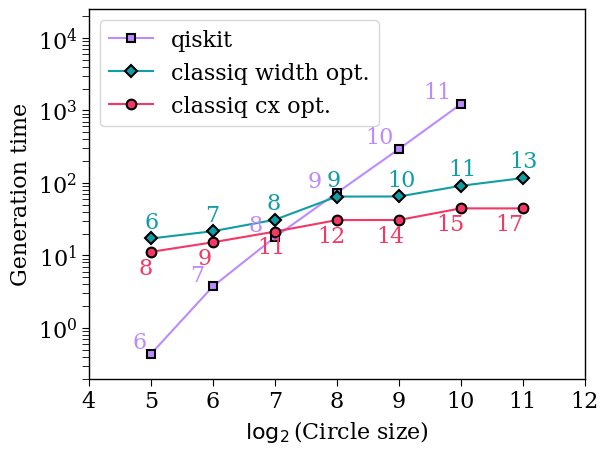

In [11]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
classiq_color_1 = "#F43764"
qiskit_color = "#bb8bff"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

(qiskit1,) = plt.semilogy(
    num_qubits_qiskit,
    qiskit_times,
    "-s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=6,
    markeredgewidth=1.5,
    color=qiskit_color,
)

(classiq1,) = plt.semilogy(
    num_qubits_classiq,
    classiq_times_opt_width,
    "-D",
    label="classiq width opt.",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=6.5,
    markeredgewidth=1.5,
    color=classiq_color,
)

(classiq2,) = plt.semilogy(
    num_qubits_classiq,
    classiq_times_opt_cx,
    "-o",
    label="classiq cx opt.",
    markerfacecolor=classiq_color_1,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color_1,
)

first_legend = plt.legend(
    handles=[qiskit1, classiq1, classiq2], fontsize=16, loc="upper left"
)


plt.ylabel("Generation time", fontsize=16)
plt.xlabel(r"$\log_2$(Circle size)", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axis(ymin=2e-1, ymax=2.5e4, xmin=4, xmax=12)


for x, y, num_qubits in zip(
    num_qubits_classiq, classiq_times_opt_width, classiq_widths_opt_width
):
    plt.text(x * 0.98, y * 1.4, str(num_qubits), fontsize=16, color=classiq_color)

for x, y, num_qubits in zip(
    num_qubits_classiq,
    classiq_times_opt_cx,
    classiq_widths_opt_cx,
):
    plt.text(x * 0.96, y * 0.5, str(num_qubits), fontsize=16, color=classiq_color_1)
for x, y, num_qubits in zip(num_qubits_qiskit, qiskit_times, qiskit_widths):
    plt.text(x * 0.94, y * 1.2, str(num_qubits), fontsize=16, color=qiskit_color)

## Synthesizing large-scale examples

We have extended the above model to larger and larger circle sizes. The results are saved in a `csv` file.

In [12]:
ind_for_plot = [0, 5, 10, 12, 14] + [k for k in range(15, 23)]

In [13]:
import pandas as pd

input_file = "results.csv"

# reading CSV file
data = pd.read_csv(input_file)  # this data is with cx optimization and max_width=100

# converting column data to list
num_qubits_cx_opt = [data["log2_circle_size_cx_opt"].tolist()[k] for k in ind_for_plot]
cx_cx_opt = [data["cx_cx_opt"].tolist()[k] for k in ind_for_plot]
time_cx_opt = [data["time_cx_opt"].tolist()[k] for k in ind_for_plot]
width_cx_opt = [data["width_cx_opt"].tolist()[k] for k in ind_for_plot]

# converting column data to list
num_qubits_width_opt = [
    data["log2_circle_size_width_opt"].tolist()[k] for k in ind_for_plot
]
cx_width_opt = [data["cx_width_opt"].tolist()[k] for k in ind_for_plot]
time_width_opt = [data["time_width_opt"].tolist()[k] for k in ind_for_plot]
width_width_opt = [data["width_width_opt"].tolist()[k] for k in ind_for_plot]

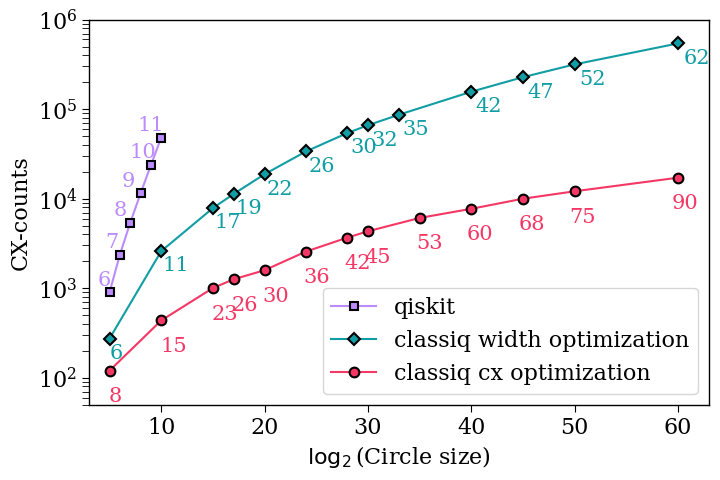

In [14]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
classiq_color_1 = "#F43764"
qiskit_color = "#bb8bff"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5
plt.figure(figsize=(8, 5))

(qiskit1,) = plt.semilogy(
    num_qubits_qiskit,
    qiskit_cx_counts,
    "-s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=6,
    markeredgewidth=1.5,
    color=qiskit_color,
)

(classiq1,) = plt.semilogy(
    num_qubits_width_opt,
    cx_width_opt,
    "-D",
    label="classiq width optimization",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=6.5,
    markeredgewidth=1.5,
    color=classiq_color,
)

(classiq2,) = plt.semilogy(
    num_qubits_cx_opt,
    cx_cx_opt,
    "-o",
    label="classiq cx optimization",
    markerfacecolor=classiq_color_1,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color_1,
)


first_legend = plt.legend(
    handles=[qiskit1, classiq1, classiq2], fontsize=16, loc="lower right"
)


plt.ylabel("CX-counts", fontsize=16)
plt.xlabel(r"$\log_2$(Circle size)", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axis(ymin=0.5e2, ymax=1e6, xmin=3, xmax=63)
# plt.xticks(num_qubits_opt_cx_max_width)


for x, y, num_qubits in zip(num_qubits_width_opt, cx_width_opt, width_width_opt):
    plt.text(x * 1.01, y * 0.6, str(num_qubits), fontsize=15, color=classiq_color)

for x, y, num_qubits in zip(
    num_qubits_cx_opt,
    cx_cx_opt,
    width_cx_opt,
):
    plt.text(x * 0.99, y * 0.45, str(num_qubits), fontsize=15, color=classiq_color_1)
for x, y, num_qubits in zip(num_qubits_qiskit, qiskit_cx_counts, qiskit_widths):
    plt.text(x * 0.77, y * 1.2, str(num_qubits), fontsize=15, color=qiskit_color)

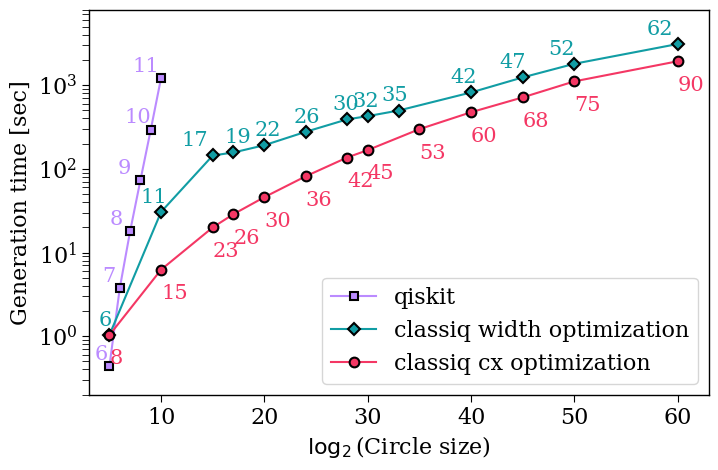

In [15]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
classiq_color_1 = "#F43764"
qiskit_color = "#bb8bff"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5
plt.figure(figsize=(8, 5))


(qiskit1,) = plt.semilogy(
    num_qubits_qiskit,
    qiskit_times,
    "-s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=6,
    markeredgewidth=1.5,
    color=qiskit_color,
)

(classiq1,) = plt.semilogy(
    num_qubits_width_opt,
    time_width_opt,
    "-D",
    label="classiq width optimization",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=6.5,
    markeredgewidth=1.5,
    color=classiq_color,
)

(classiq2,) = plt.semilogy(
    num_qubits_cx_opt,
    time_cx_opt,
    "-o",
    label="classiq cx optimization",
    markerfacecolor=classiq_color_1,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color_1,
)


first_legend = plt.legend(
    handles=[qiskit1, classiq1, classiq2], fontsize=16, loc="lower right"
)


plt.ylabel("Generation time [sec]", fontsize=16)
plt.xlabel(r"$\log_2$(Circle size)", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axis(ymin=0.2, ymax=8e3, xmin=3, xmax=63)


for x, y, num_qubits in zip(num_qubits_width_opt, time_width_opt, width_width_opt):
    if num_qubits < 19:
        plt.text(x * 0.8, y * 1.3, str(num_qubits), fontsize=15, color=classiq_color)
    else:
        plt.text(x * 0.95, y * 1.3, str(num_qubits), fontsize=15, color=classiq_color)

for x, y, num_qubits in zip(
    num_qubits_cx_opt,
    time_cx_opt,
    width_cx_opt,
):
    plt.text(x * 1.0, y * 0.45, str(num_qubits), fontsize=15, color=classiq_color_1)
for x, y, num_qubits in zip(num_qubits_qiskit, qiskit_times, qiskit_widths):
    plt.text(x * 0.72, y * 1.2, str(num_qubits), fontsize=15, color=qiskit_color)